# PACKAGES

In [1]:
import pandas as pd
import numpy as np
import datatable as dt
from transformers import BertTokenizer, BertModel, BertConfig, TFBertModel
import emoji
import torch
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, BatchNormalization, Bidirectional, GRU, Dense, Input
import tensorflow as tf
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import gc
from keras.callbacks import Callback
from keras import backend as K

/home/amirabbas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-12 18:35:34.227857: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 18:35:34.251145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 18:35:34.251171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 18:35:34.251989: 

# LOAD DATA

In [2]:
train_data = pd.read_csv('./Train.csv', dtype={'tweet': str})
test_data = pd.read_csv('./Test.csv', dtype={'tweet': str})
val_data = pd.read_csv('./Val.csv', dtype={'tweet': str})
data = {'train': train_data, 'test': test_data, 'val': val_data}
for key in data.keys():
    data[key]['y'] = data[key]['label'].apply(lambda x: 1 if x == 'real' else 0)
    data[key].drop(columns=['label'], axis = 1, inplace=True)

# TOKENIZING AND DEMOJIZING TEXT

In [3]:
def make_token(data):# Initialize the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def emoji_to_text(text):
        return emoji.demojize(text)

    # Apply the tokenizer to the text column
    data['tweet'] = data['tweet'].apply(emoji_to_text)
    inputs = tokenizer(data['tweet'].to_list(), padding=True, truncation=True, max_length = 128, return_tensors="tf")
    dataset = tf.data.Dataset.from_tensor_slices(((
        inputs['input_ids'],
        inputs['attention_mask'],
        inputs['token_type_ids']),
        data['y']
    ))
    return dataset

for df in data.keys():
    data[df] = make_token(data[df])

2024-06-12 18:35:38.905290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 18:35:38.905959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 18:35:38.906035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# MODELS

## BertBase+FC

In [5]:
class BertBase:
    def __init__(self, data:dict, batch_size, epochs, trainable = False):
        self.batch_size = batch_size
        self.epochs = epochs
        self.data = data
        self.trainable = trainable
        for df in data.keys():
            data[df] = data[df].shuffle(len(data[df])).batch(self.batch_size)
        self.model = self.make_model()
    
    def make_model(self):
        # BERT model
        bert = TFBertModel.from_pretrained('bert-base-uncased')
        bert.trainable = self.trainable
        # Input layers
        input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
        token_type_ids = Input(shape=(None,), dtype=tf.int32, name='token_type_ids')
        
        # BERT embeddings
        bert_outputs = bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_embedding = bert_outputs.last_hidden_state[:, 0, :]
        
        #dropout
        batch = BatchNormalization()(cls_embedding)

        # Fully connected layer
        dense = Dense(1, activation='sigmoid')(batch)
        
        # Model
        model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=dense)
        
        return model

    def train(self):
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate = 2e-5), loss='BinaryCrossentropy', metrics=['accuracy'])
        return self.model.fit(data['train'], epochs=self.epochs, batch_size=self.batch_size, validation_data=data['val'])
    
    def test(self):
        return self.model.evaluate(data['test'], batch_size = self.batch_size)

## BertBase+GRU

In [6]:
class BertBase_GRU:
    def __init__(self, data:dict, batch_size, epochs, trainable = False):
        self.batch_size = batch_size
        self.epochs = epochs
        self.data = data
        self.trainable = trainable
        for df in data.keys():
            data[df] = data[df].shuffle(len(data[df])).batch(self.batch_size)
        self.model = self.make_model()
    
    def make_model(self):
        # BERT model
        bert = TFBertModel.from_pretrained('bert-base-uncased')
        bert.trainable = self.trainable
        # Input layers
        input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
        token_type_ids = Input(shape=(None,), dtype=tf.int32, name='token_type_ids')
        
        # BERT embeddings
        bert_outputs = bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        embedding = bert_outputs.last_hidden_state
        
        #normalization
        embedding = BatchNormalization()(embedding)
    
        # BiGRU layer
        bi_gru = Bidirectional(GRU(128, return_sequences=False, recurrent_dropout=0.5, dropout = 0.5))(embedding)
        
        # Dropout layer
        dropout = Dropout(0.5)(bi_gru)
        
        # Fully connected layer
        dense = Dense(1, activation='sigmoid')(dropout)
        
        # Model
        model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=dense)
        
        return model

    def train(self):
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate = 2e-5), loss='BinaryCrossentropy', metrics=['accuracy'])
        return self.model.fit(data['train'], epochs=self.epochs, batch_size=self.batch_size, validation_data=data['val'])
    
    def test(self):
        return self.model.evaluate(data['test'], batch_size = self.batch_size)

## CTBert+GRU

In [7]:
class CTBert_GRU:
    def __init__(self, data:dict, batch_size, epochs, trainable = False):
        self.batch_size = batch_size
        self.epochs = epochs
        self.data = data
        self.trainable = trainable
        for df in data.keys():
            data[df] = data[df].shuffle(len(data[df])).batch(self.batch_size)
        self.model = self.make_model()
    
    def make_model(self):
        # BERT model        
        bert = TFBertModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert')
        bert.trainable = self.trainable
        # Input layers
        input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
        token_type_ids = Input(shape=(None,), dtype=tf.int32, name='token_type_ids')
        
        # BERT embeddings
        bert_outputs = bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        embedding = bert_outputs.last_hidden_state
        
        #normalization
        embedding = BatchNormalization()(embedding)
    
        # BiGRU layer
        bi_gru = Bidirectional(GRU(128, return_sequences=False, recurrent_dropout=0.5, dropout = 0.5))(embedding)
        
        # Dropout layer
        dropout = Dropout(0.5)(bi_gru)
        
        # Fully connected layer
        dense = Dense(1, activation='sigmoid')(dropout)
        
        # Model
        model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=dense)
        
        return model

    def train(self):
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5), loss='BinaryCrossentropy', metrics=['accuracy'])
        return self.model.fit(data['train'], epochs=self.epochs, batch_size=self.batch_size, validation_data=data['val'], callbacks=[ClearMemory()])
    
    def test(self):
        return self.model.evaluate(data['test'], batch_size = self.batch_size)

# METRICS

In [8]:
def evaluate_model(model, data, batch_size = 4):
        y_true = []
        y_pred = []
        for batch in data['test']:
            input_ids, attention_mask, token_type_ids = batch[0][0], batch[0][1], batch[0][2]
            y_true.extend(batch[1].numpy())
            predictions = model.predict([input_ids, attention_mask, token_type_ids], verbose = 0)
            y_pred.extend((predictions >= 0.5).astype(int).flatten())
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        return f1, cm

# Train and Validation Loss and Accuracy

In [9]:
def plot_history(history, name):
        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(name)
        plt.tight_layout()
        plt.show()

# FEATURE BASE

## BertBase_GRU

In [65]:
bertBase_gru = BertBase_GRU(data, 4, 3, False)
bertBase_gru_history = bertBase_gru.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1605/1605 [==============================] - 347s 212ms/step - loss: 0.4294 - accuracy: 0.8061 - val_loss: 0.2673 - val_accuracy: 0.8846
Epoch 2/3
1605/1605 [==============================] - 337s 210ms/step - loss: 0.3023 - accuracy: 0.8709 - val_loss: 0.2444 - val_accuracy: 0.8930
Epoch 3/3
1605/1605 [==============================] - 335s 209ms/step - loss: 0.2647 - accuracy: 0.8908 - val_loss: 0.2003 - val_accuracy: 0.9173


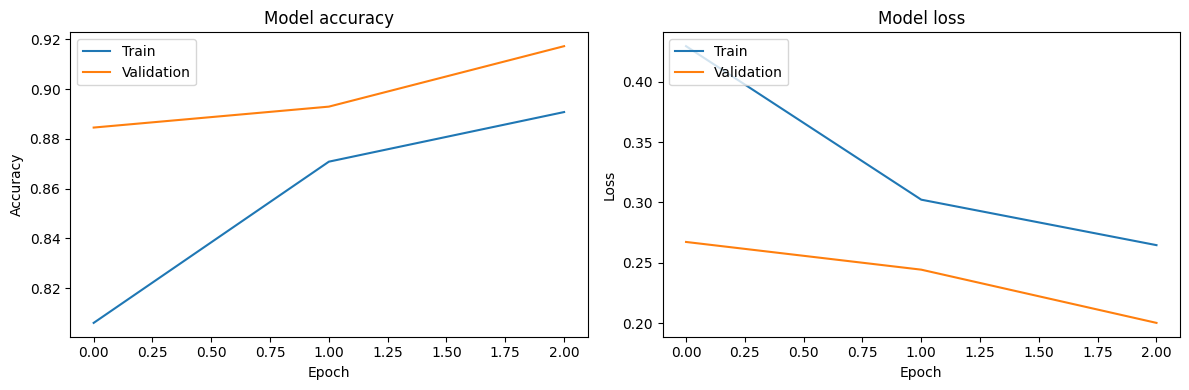

535/535 [==============================] - 27s 50ms/step - loss: 0.2052 - accuracy: 0.9182
Model loss and accuracy:  [0.2051621973514557, 0.9182242751121521]
bertBase_gru F1:  0.9251176722293538
bertBase_gru Confusion Matrix:
 [[ 884  136]
 [  39 1081]]


In [74]:
plot_history(bertBase_gru_history, 'bertBase_gru')
print('Model loss and accuracy: ', bertBase_gru.test())
f1, cm = evaluate_model(bertBase_gru.model, bertBase_gru.data, 4)
print('bertBase_gru F1: ', f1)
print('bertBase_gru Confusion Matrix:\n', cm)

## BertBase

In [87]:
bertBase = BertBase(data, 4, 3, False)
bertBase_history = bertBase.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1605/1605 [==============================] - 64s 37ms/step - loss: 0.6888 - accuracy: 0.6241 - val_loss: 0.4683 - val_accuracy: 0.7757
Epoch 2/3
1605/1605 [==============================] - 59s 37ms/step - loss: 0.5441 - accuracy: 0.7296 - val_loss: 0.3711 - val_accuracy: 0.8379
Epoch 3/3
1605/1605 [==============================] - 61s 38ms/step - loss: 0.5053 - accuracy: 0.7569 - val_loss: 0.3258 - val_accuracy: 0.8561


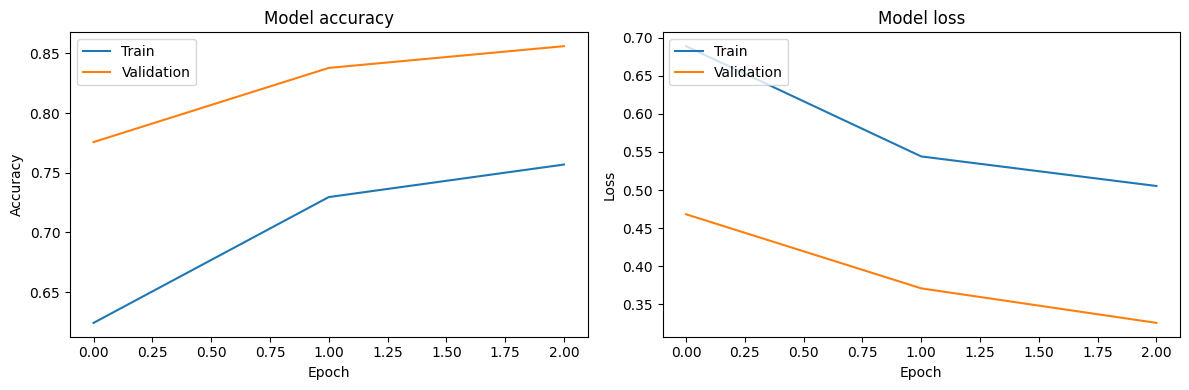

535/535 [==============================] - 15s 28ms/step - loss: 0.3333 - accuracy: 0.8551
Model loss and accuracy:  [0.33327388763427734, 0.855140209197998]
bertBase_gru F1:  0.8732624693376942
bertBase_gru Confusion Matrix:
 [[ 762  258]
 [  52 1068]]


In [88]:
print(bertBase_history)
plot_history(bertBase_history, 'bertBase')
print('Model loss and accuracy: ', bertBase.test())
f1, cm = evaluate_model(bertBase.model, bertBase.data, 4)
print('bertBase_gru F1: ', f1)
print('bertBase_gru Confusion Matrix:\n', cm)

## CTBert

In [21]:
ctbert_gru = CTBert_GRU(data, 4, 3, False)
ctbert_gru_history = ctbert_gru.train()

Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3


2024-06-12 17:06:02.979304: I external/local_xla/xla/service/service.cc:168] XLA service 0x74d1b53eb410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 17:06:02.979327: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-06-12 17:06:02.987788: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-12 17:06:03.005629: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1718199363.054465   12484 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1605/1605 [==============================] - 471s 286ms/step - loss: 0.6210 - accuracy: 0.6612 - val_loss: 0.3367 - val_accuracy: 0.8612
Epoch 2/3
1605/1605 [==============================] - 435s 270ms/step - loss: 0.4468 - accuracy: 0.7913 - val_loss: 0.2560 - val_accuracy: 0.8967
Epoch 3/3
1605/1605 [==============================] - 434s 269ms/step - loss: 0.3732 - accuracy: 0.8364 - val_loss: 0.2133 - val_accuracy: 0.9117


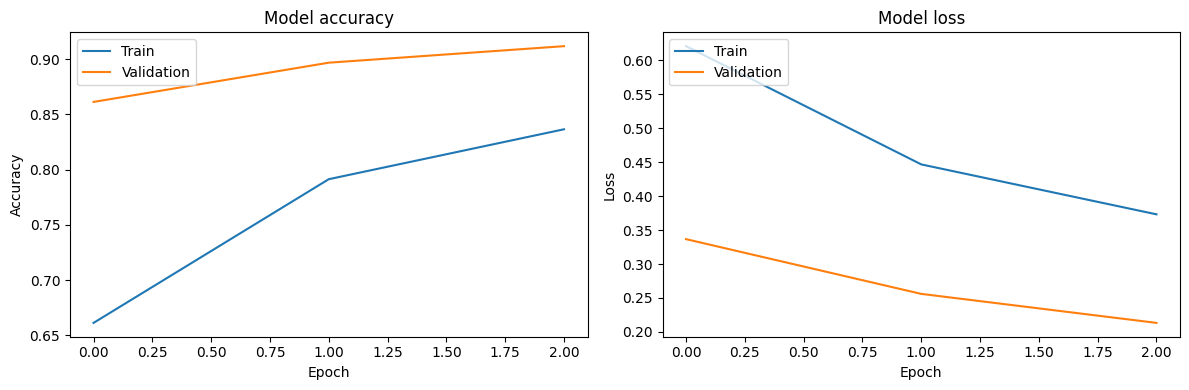

535/535 [==============================] - 53s 97ms/step - loss: 0.2146 - accuracy: 0.9112
Model loss and accuracy:  [0.2146323174238205, 0.9112149477005005]
bertBase_gru F1:  0.9175347222222222
bertBase_gru Confusion Matrix:
 [[ 893  127]
 [  63 1057]]


In [22]:
plot_history(ctbert_gru_history, 'ctbert_gru')
print('Model loss and accuracy: ', ctbert_gru.test())
f1, cm = evaluate_model(ctbert_gru.model, ctbert_gru.data, 4)
print('bertBase_gru F1: ', f1)
print('bertBase_gru Confusion Matrix:\n', cm)

# FINE TUNING

## BertBase_GRU

In [39]:
bertBase_gru_fine = BertBase_GRU(data, 4, 3, True)
bertBase_gru_fine_history = bertBase_gru_fine.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1605/1605 [==============================] - 454s 271ms/step - loss: 0.2423 - accuracy: 0.9011 - val_loss: 0.1384 - val_accuracy: 0.9551
Epoch 2/3
1605/1605 [==============================] - 432s 269ms/step - loss: 0.0836 - accuracy: 0.9737 - val_loss: 0.1184 - val_accuracy: 0.9682
Epoch 3/3
1605/1605 [==============================] - 432s 269ms/step - loss: 0.0449 - accuracy: 0.9879 - val_loss: 0.1147 - val_accuracy: 0.9687


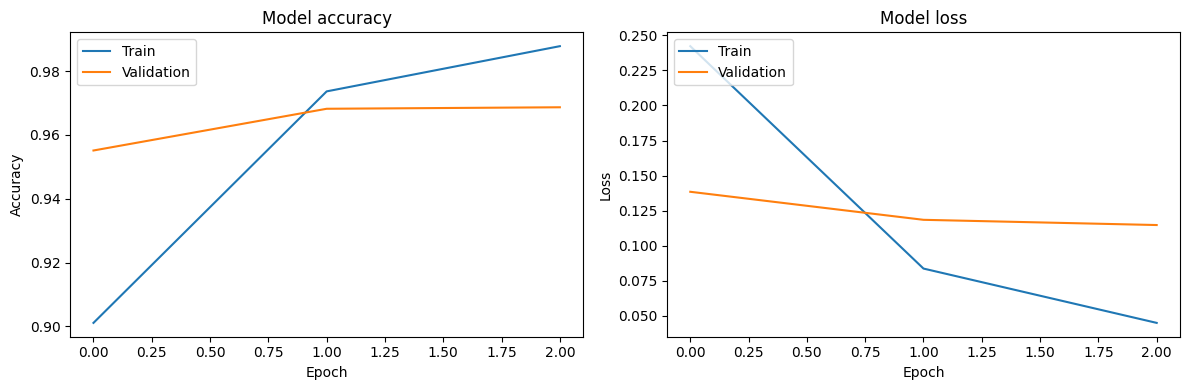

535/535 [==============================] - 26s 49ms/step - loss: 0.1142 - accuracy: 0.9678
Model loss and accuracy:  [0.11424735188484192, 0.967756986618042]
bertBase_gru F1:  0.9696703296703297
bertBase_gru Confusion Matrix:
 [[ 968   52]
 [  17 1103]]


In [40]:
plot_history(bertBase_gru_fine_history, 'bertBase_gru_fine')
print('Model loss and accuracy: ', bertBase_gru_fine.test())
f1, cm = evaluate_model(bertBase_gru_fine.model, bertBase_gru_fine.data, 4)
print('bertBase_gru F1: ', f1)
print('bertBase_gru Confusion Matrix:\n', cm)

## BertBase

In [15]:
bertBase_fine = BertBase(data, 4, 3, True)
bertBase_fine_history = bertBase_fine.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
1605/1605 [==============================] - 185s 104ms/step - loss: 0.3474 - accuracy: 0.8614 - val_loss: 0.0967 - val_accuracy: 0.9682
Epoch 2/3
1605/1605 [==============================] - 168s 104ms/step - loss: 0.2224 - accuracy: 0.9042 - val_loss: 0.1253 - val_accuracy: 0.9706
Epoch 3/3
1605/1605 [==============================] - 169s 105ms/step - loss: 0.1626 - accuracy: 0.9237 - val_loss: 0.2847 - val_accuracy: 0.9626


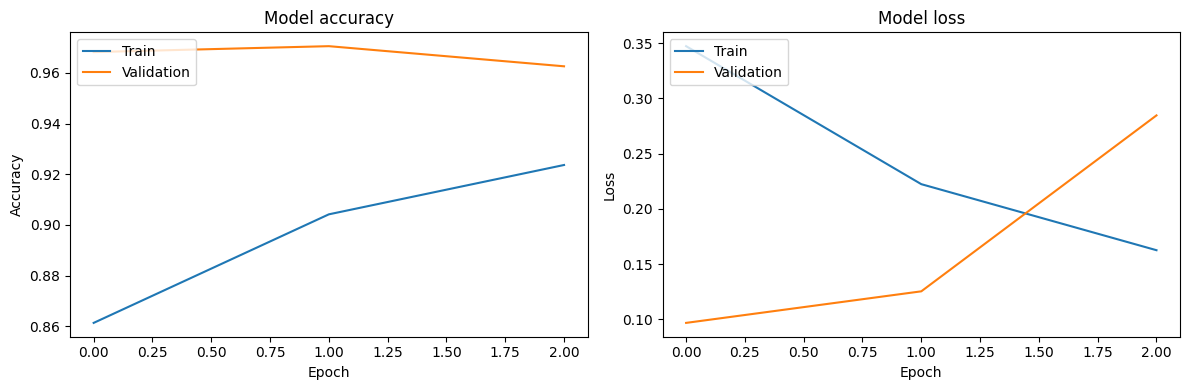

535/535 [==============================] - 15s 28ms/step - loss: 0.3118 - accuracy: 0.9542
Model loss and accuracy:  [0.3118341863155365, 0.9542056322097778]
bertBase_gru F1:  0.957975986277873
bertBase_gru Confusion Matrix:
 [[ 925   95]
 [   3 1117]]


In [16]:
plot_history(bertBase_fine_history, 'bertBase_fine')
print('Model loss and accuracy: ', bertBase_fine.test())
f1, cm = evaluate_model(bertBase_fine.model, bertBase_fine.data, 4)
print('bertBase_gru F1: ', f1)
print('bertBase_gru Confusion Matrix:\n', cm)

## CTBert

In [10]:
ctbert_gru_fine = CTBert_GRU(data, 4, 3, True)
ctbert_gru_fine_history = ctbert_gru_fine.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

2024-06-12 18:05:30.896237: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/3


2024-06-12 18:05:44.072191: I external/local_xla/xla/service/service.cc:168] XLA service 0x7aaae0439780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 18:05:44.072212: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-06-12 18:05:44.075430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-12 18:05:44.084165: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1718202944.128966   43165 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1605/1605 [==============================] - 471s 281ms/step - loss: 0.0367 - accuracy: 0.9882 - val_loss: 0.0882 - val_accuracy: 0.9780
Epoch 2/3
1605/1605 [==============================] - 461s 288ms/step - loss: 0.0190 - accuracy: 0.9947 - val_loss: 0.1395 - val_accuracy: 0.9701
Epoch 3/3
1605/1605 [==============================] - 464s 289ms/step - loss: 0.0214 - accuracy: 0.9935 - val_loss: 0.1244 - val_accuracy: 0.9757


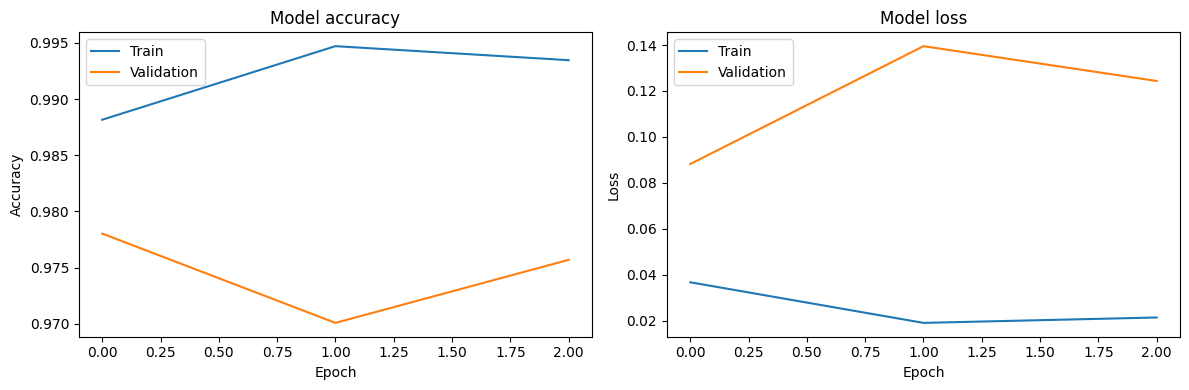

535/535 [==============================] - 27s 50ms/step - loss: 0.1414 - accuracy: 0.9734
Model loss and accuracy:  [0.1413976103067398, 0.9733644723892212]
bertBase_gru F1:  0.9749230092388913
bertBase_gru Confusion Matrix:
 [[ 975   45]
 [  12 1108]]


In [11]:
plot_history(ctbert_gru_fine_history, 'ctbert_gru_fine')
print('Model loss and accuracy: ', ctbert_gru_fine.test())
f1, cm = evaluate_model(ctbert_gru_fine.model, ctbert_gru_fine.data, 4)
print('bertBase_gru F1: ', f1)
print('bertBase_gru Confusion Matrix:\n', cm)